Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")


df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [4]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 2.52 s


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.])

In [12]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.74      0.61      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.79     13567
weighted avg       0.84      0.85      0.84     13567



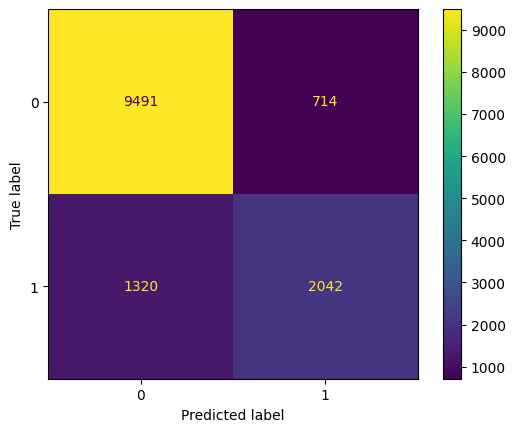

In [7]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [9]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='race',
    freqitem_minsupp=0.05,
    missing_subgroup_val="Unknown",
    drop_infeasible=True,
    drop_above=True
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2407/2407 [00:00<00:00, 251511.95it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 1159/1159 [00:00<00:00, 18661.32it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 2377/2377 [02:42<00:00, 14.62it/s]


Number of if-thens: 2377


In [8]:
### Uncomment if you wish to load rules object from disk

import dill

with open("rulesAdultFairTest_race.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [9]:
### Uncomment if you wish to save rules object on disk

import dill

with open("rulesAdultFairTest_race.data", "wb") as outf:
    dill.dump(rules_by_if, outf)

In [ ]:
# rules = {}
# features = ['capital-gain','capital-loss']
# for rule in rules_by_if.keys():
#     if all(f not in features for f in rule.features):
#         rules[rule] = rules_by_if[rule]

In [10]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" White"][1][0][1]-e[1][" Black"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If age = (26.0, 34.0], marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Asian-Pac-Islander', 9.75% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 66.67%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 55.56%.
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 25.93%.
	Protected Subgroup ' Amer-Indian-Eskimo', 6.72% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 0.00%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 0.00%.
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 0.00%.
	Protected Subgroup ' Black', 6.81% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 19.51%.


# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [11]:
feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    feature_weights=feature_weights,
    num_normalization=True
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [13]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 200,
    filter_sequence = [
        "remove-contained",
        # "remove-below-thr",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=None,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Asian-Pac-Islander', 94.58% covered out of 277
		Make capital-gain = 15024 with correctness 81.68%.
		Aggregate cost of the above recourses = -5.44
	Protected Subgroup ' Amer-Indian-Eskimo', 96.64% covered out of 119
		Make capital-gain = 15024 with correctness 78.26%.
		Aggregate cost of the above recourses = -5.21
	Protected Subgroup ' Black', 93.36% covered out of 1204
		Make capital-gain = 15024 with correctness 67.79%.
		Aggregate cost of the above recourses = -4.51
	Protected Subgroup ' Other', 95.00% covered out of 100
		Make capital-gain = 15024 with correctness 78.95%.
		Aggregate cost of the above recourses = -5.25
	Protected Subgroup ' White', 94.14% covered out of 9111
		Make capital-gain = 15024 with correctness 80.55%.
		Aggregate cost of the above recourses = -5.36
	Bias against  Black. Unfairness measure = 0.92.
If capital-gain = 0, occupation =  Other-service, sex =  Male:
	Protected Subgroup ' Asian-Pac-Isla

## Minimum cost above threshold

In [20]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=20,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If hours-per-week = FullTime, occupation =  Craft-repair:
	Protected Subgroup ' Asian-Pac-Islander', 6.86% covered out of 277
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 31.58%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 31.58%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 31.58%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 31.58%.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup ' Amer-Indian-Eskimo', 5.88% covered out of 119
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 28.57%.
		Make occupation =  Prof-specialty with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 28.57%.
		Make occupation =  Exec-managerial with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 28.57%.
		Make hours-per-week 

## Mean cost above threshold

In [19]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=100,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Asian-Pac-Islander', 22.74% covered out of 277
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 26.98%.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' Amer-Indian-Eskimo', 14.29% covered out of 119
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Black', 16.36% covered out of 1204
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Other', 20.00% covered out of 100
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' White', 18.53% covered out of 9111
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 25.06%.
		Aggregate cost of the above recourses = 11.00
	Bias against  Amer-Indian-Eskimo. Unfairness measure = inf.
If Workclass =  Private, marital-status 

## Number above threshold

In [18]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If hours-per-week = FullTime, occupation =  Craft-repair:
	Protected Subgroup ' Asian-Pac-Islander', 6.86% covered out of 277
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 31.58%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 31.58%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 31.58%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 31.58%.
		Aggregate cost of the above recourses = -4.00
	Protected Subgroup ' Amer-Indian-Eskimo', 5.88% covered out of 119
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 28.57%.
		Make occupation =  Prof-specialty with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 28.57%.
		Make occupation =  Exec-managerial with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 28.57%.
		Make hours-per-week

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [17]:
import dill

with open("stateAdultFairTest.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

If hours-per-week = FullTime, occupation =  Craft-repair:
	Protected Subgroup ' Asian-Pac-Islander', 6.86% covered out of 1303
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 31.58%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 31.58%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 31.58%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 31.58%.
	Protected Subgroup ' Amer-Indian-Eskimo', 5.88% covered out of 435
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 28.57%.
		Make occupation =  Prof-specialty with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 28.57%.
		Make occupation =  Exec-managerial with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 28.57%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial wi

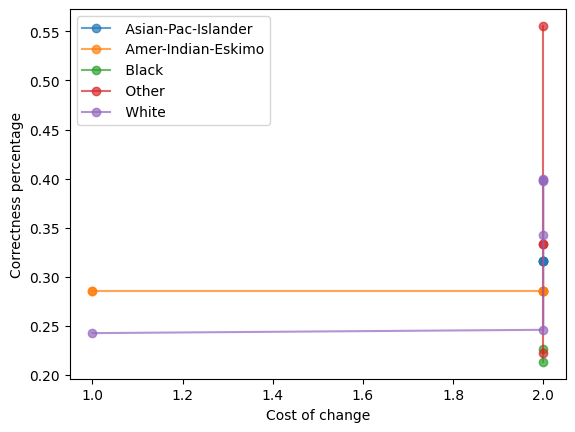

If Workclass =  Private, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Asian-Pac-Islander', 20.22% covered out of 1303
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 26.79%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.93%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 21.43%.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 23.21%.
	Protected Subgroup ' Amer-Indian-Eskimo', 10.92% covered out of 435
		No recourses for this subgroup!
	Protected Subgroup ' Black', 11.96% covered out of 4228
		No recourses for this subgroup!
	Protected Subgroup ' Other', 16.00% covered out of 353
		No recourses for this subgroup!
	Protected Subgroup ' White', 14.78% covered out of 38903
		Make marital-status =  Married-civ-spouse, rel

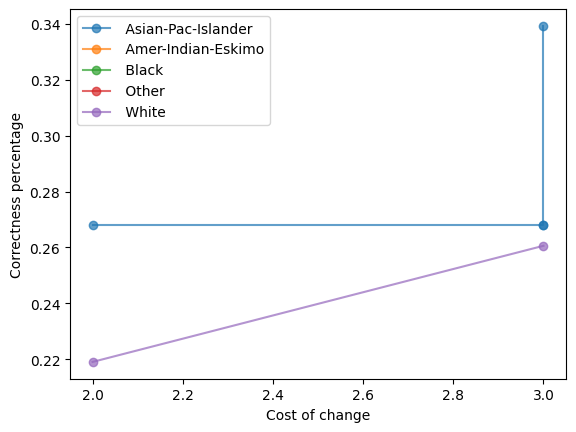

If capital-gain = 0, hours-per-week = FullTime, occupation =  Craft-repair:
	Protected Subgroup ' Asian-Pac-Islander', 6.86% covered out of 1303
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 31.58%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 31.58%.
	Protected Subgroup ' Amer-Indian-Eskimo', 5.88% covered out of 435
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 28.57%.
		Make occupation =  Prof-specialty with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 28.57%.
		Make occupation =  Exec-managerial with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 28.57%.
	Protected Subgroup ' Black', 5.90% covered out of 4228
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 21.13%.
	Protected Subgroup ' Other', 7.00% covered out of 353
		Make hours-per-week = OverTim

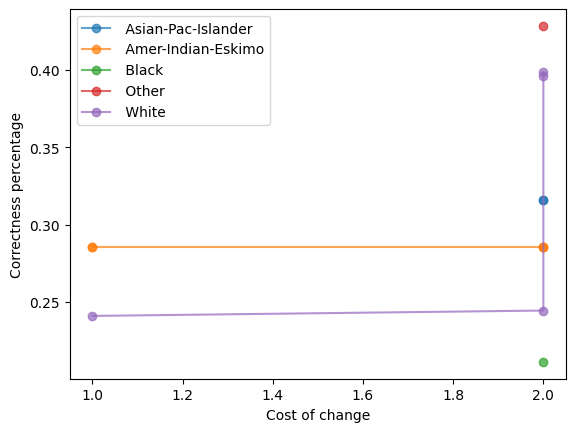

If Workclass =  Private, hours-per-week = FullTime, occupation =  Craft-repair:
	Protected Subgroup ' Asian-Pac-Islander', 6.50% covered out of 1303
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 33.33%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 33.33%.
	Protected Subgroup ' Amer-Indian-Eskimo', 5.04% covered out of 435
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 33.33%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 33.33%.
		Make occupation =  Prof-specialty with correctness 33.33%.
		Make occupation =  Exec-managerial with correctness 33.33%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 33.33%.
	Protected Subgroup ' Black', 5.32% covered out of 4228
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 21.88%.
	Protected Subgroup ' Other', 9.00% covered out of 353
		Make hours-per-week = Ove

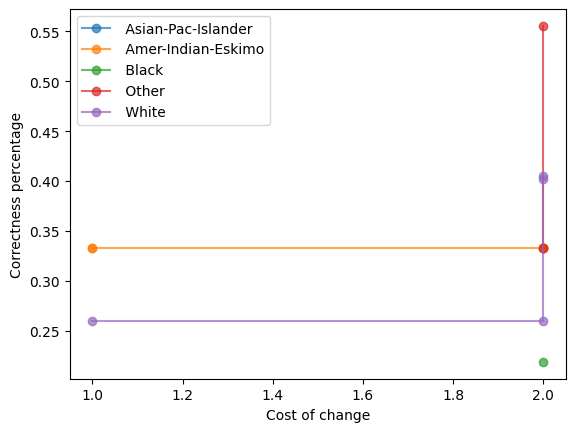

If capital-loss = 0, hours-per-week = FullTime, occupation =  Craft-repair:
	Protected Subgroup ' Asian-Pac-Islander', 6.50% covered out of 1303
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 33.33%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 33.33%.
	Protected Subgroup ' Amer-Indian-Eskimo', 5.88% covered out of 435
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 28.57%.
		Make occupation =  Prof-specialty with correctness 28.57%.
		Make occupation =  Exec-managerial with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 28.57%.
	Protected Subgroup ' Black', 6.15% covered out of 4228
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 21.62%.
	Protected Subgroup ' Other', 9.00% covered out of 353
		Make hours-per-week = OverTim

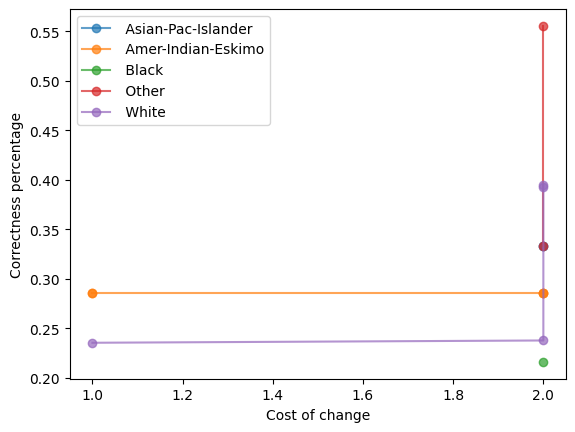

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, occupation =  Craft-repair:
	Protected Subgroup ' Asian-Pac-Islander', 6.50% covered out of 1303
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 33.33%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 33.33%.
	Protected Subgroup ' Amer-Indian-Eskimo', 5.88% covered out of 435
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 28.57%.
		Make occupation =  Prof-specialty with correctness 28.57%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 28.57%.
		Make occupation =  Exec-managerial with correctness 28.57%.
	Protected Subgroup ' Black', 5.81% covered out of 4228
		No recourses for this subgroup!
	Protected Subgroup ' Other', 7.00% covered out of 353
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 42.86%.
	Protected Subgroup ' White', 9.25% covered out of 38903
	

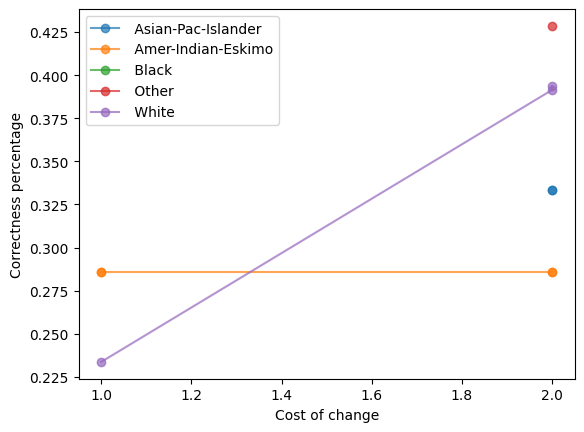

If Workclass =  Private, capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Asian-Pac-Islander', 19.49% covered out of 1303
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 25.93%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 33.33%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 20.37%.
	Protected Subgroup ' Amer-Indian-Eskimo', 10.92% covered out of 435
		No recourses for this subgroup!
	Protected Subgroup ' Black', 11.71% covered out of 4228
		No recourses for this subgroup!
	Protected Subgroup ' Other', 16.00% covered out of 353
		No recourses for this subgroup!
	Protected Subgroup ' White', 14.15% covered out of 38903
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 24.13%.
	Bias against  Amer-Indian-

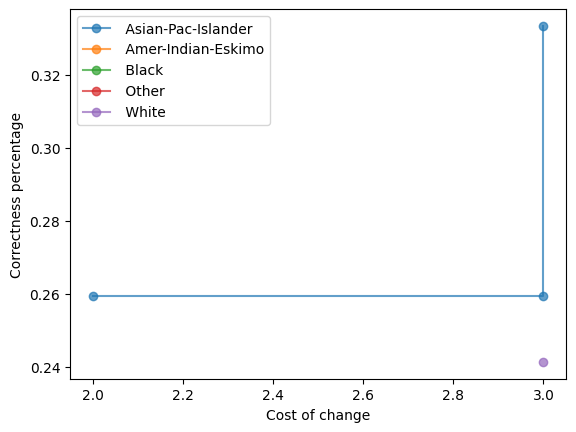

If Workclass =  Private, marital-status =  Never-married, relationship =  Not-in-family, sex =  Male:
	Protected Subgroup ' Asian-Pac-Islander', 10.47% covered out of 1303
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.03%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 41.38%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 20.69%.
	Protected Subgroup ' Amer-Indian-Eskimo', 7.56% covered out of 435
		No recourses for this subgroup!
	Protected Subgroup ' Black', 6.89% covered out of 4228
		No recourses for this subgroup!
	Protected Subgroup ' Other', 13.00% covered out of 353
		No recourses for this subgroup!
	Protected Subgroup ' White', 8.37% covered out of 38903
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 21.23%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-ci

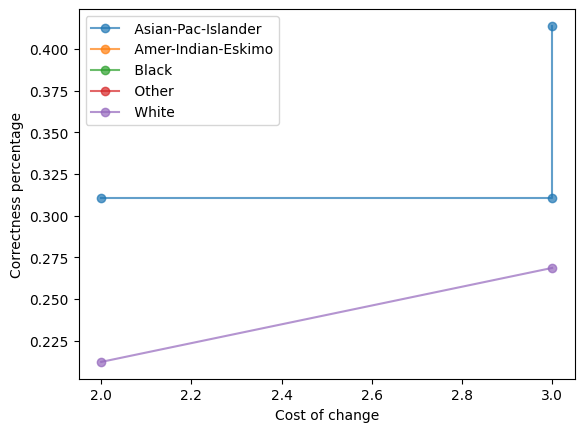

If Workclass =  Private, capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family, sex =  Male:
	Protected Subgroup ' Asian-Pac-Islander', 10.47% covered out of 1303
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 31.03%.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 41.38%.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, relationship =  Married with correctness 20.69%.
	Protected Subgroup ' Amer-Indian-Eskimo', 7.56% covered out of 435
		No recourses for this subgroup!
	Protected Subgroup ' Black', 6.73% covered out of 4228
		No recourses for this subgroup!
	Protected Subgroup ' Other', 13.00% covered out of 353
		No recourses for this subgroup!
	Protected Subgroup ' White', 8.00% covered out of 38903
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with correctness 24.69%.
	Bias against  Am

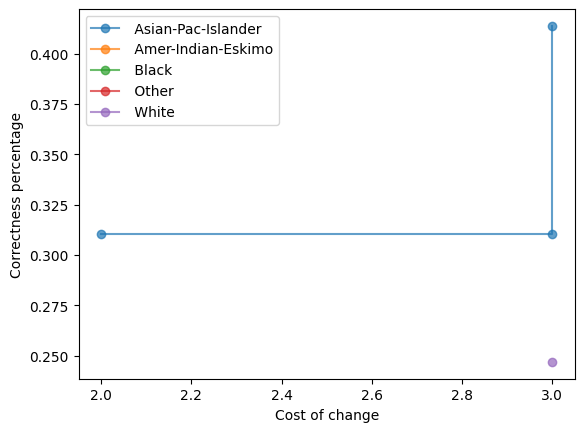

If age = (26.0, 34.0], capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Asian-Pac-Islander', 9.75% covered out of 1303
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 66.67%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 55.56%.
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 25.93%.
	Protected Subgroup ' Amer-Indian-Eskimo', 6.72% covered out of 435
		No recourses for this subgroup!
	Protected Subgroup ' Black', 6.64% covered out of 4228
		No recourses for this subgroup!
	Protected Subgroup ' Other', 6.00% covered out of 353
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 50.00%.
	Protected Subgroup ' White', 5.52% covered out of 38903
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Marri

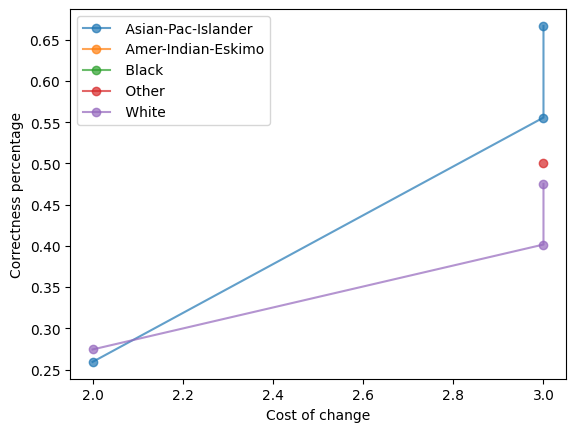

In [22]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.2,
    filter_sequence=["remove-below-thr"]
)

cum_cors = facts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="race")

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [16]:
import dill

with open("stateAdultFairTest.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)